## Viki scraping

#### Ce projet a pour but de scrapper le site web "www.viki.com", d'envoyer les informations obtenues lors du scrapping dans une base MongoDB et de récupérer des informations afin de réaliser de la data visualization

In [1]:
!pip install seaborn

     |████████████████████████████████| 285 kB 313 kB/s eta 0:00:01
     |████████████████████████████████| 27.2 MB 24 kB/s eta 0:00:01     |████████████████████▌           | 17.4 MB 45 kB/s eta 0:03:38     |██████████████████████████▍     | 22.5 MB 28 kB/s eta 0:02:48


In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

## Scraping

Nous avons décidé de créer une classe Scraper pour rassembler toutes les fonctions dont nous aurons besoin pour scraper le site web que nous avons choisi.

In [3]:
class Scraper:
    def __init__(self, url):
        self.chrome_options = webdriver.ChromeOptions()
        self.chrome_options.add_argument('--no-sandbox')
        self.chrome_options.add_argument('--window-size=1420,1080')
        self.chrome_options.add_argument('--headless')
        self.chrome_options.add_argument('--disable-gpu')
        self.chrome_options.add_argument('--disable-dev-shm-usage')  
        self.driver = webdriver.Chrome(options=self.chrome_options)
        self.url = url
    
    def access_website(self):
        self.driver.get(self.url)
        
    def click_on_by_text(self,text):
        self.driver.find_element_by_link_text(text).click()
   
    def click_on_by_xpath(self,xpath):
        self.driver.find_element_by_xpath(xpath).click()
        
    def click_on_by_id(self, id_name):
        self.driver.find_element_by_id(id_name).click()
    
    def accept_cookies(self):
        self.driver.find_element_by_xpath("//button[text()='Accept All']").click()
    
    def get_show(self, results, category):
        all_widgets = self.driver.find_elements_by_class_name("explore-results")
        first_line = all_widgets[0]
        all_first_line_elements = first_line.find_elements_by_class_name('col-inline')
        all_first_line_images = first_line.find_elements_by_css_selector('img.responsive-img')
        for i in range(len(all_first_line_elements)):
            try:
                show = all_first_line_elements[i].text.split('\n')
                details = show[1].split('•')
                votes_details = details[1].split('(')
                image = all_first_line_images[i].get_attribute('src')
                results.append({'Type': category, 'Nom': show[0], 'Pays': details[0], 'Note': votes_details[0],
                                'Nb_votes': votes_details[1].split(' ')[0], 'image': image})
            except:
                continue
        return results
    
    def get_all_shows(self, pages, category):
        results = []
        for i in range(pages):
            try:
                self.get_show(results, category)
                WebDriverWait(self.driver, 30).until(
                    EC.element_to_be_clickable((By.XPATH, "//a[text()='Suivant →']"))).click()
            except:
                continue
        return results
    
    def quitDriver(self):
        self.driver.quit()

La classe Scraper, lorsqu'on l'instancie, commence par initialiser les variables nécessaires au bout fonctionnement de la classe. L'option disable-dev-shm-usage était notamment nécessaire pour éviter que notre programme crash à chaque clic.

In [4]:
chrome = Scraper('https://www.viki.com/?locale=fr')

La fonction `access_website()` permet d'accèder au site web demandé dans l'instanciantion de la classe Scrapper juste au dessus

In [5]:
chrome.access_website()

In [6]:
chrome.accept_cookies()

Les fonctions que nous avons créer et qui permettent de cliquer sur les éléments permettant d'atteindre les pages où sont les informations des programmes Viki utilisent soit le texte sur lequel on clique, soit l'id donnez à l'élément dans le fichier HTML ou le XPath.
XPath est langage de requêtage permettant de localiser une portion d'un document XML. 

In [7]:
chrome.click_on_by_text('Explorer')

In [8]:
chrome.click_on_by_text('Tous les spectacles')

In [9]:
chrome.click_on_by_id("select2-chosen-2")

In [10]:
chrome.click_on_by_xpath("//div[text()='Télévision']")

La fonction `get_all_shows`permet d récupérer les séries ou films sur un nombre de page spécifié en argument. On spécifie aussi le type du programme que l'on récupére. Les différentes informations du programme sont stockés dans un dictionnaire. Les dictionnaires sont eux stockés dans une liste afin que cette liste soit transformé en un fichier csv à la fin du scraping. 

In [11]:
series = chrome.get_all_shows(5,'Série')

In [12]:
len(series)

62

In [13]:
chrome.click_on_by_xpath("//span[text()='Télévision']")

In [14]:
chrome.click_on_by_xpath("//div[text()='Films']")

In [15]:
movies = chrome.get_all_shows(3,'Film')

In [16]:
chrome.quitDriver()

In [17]:
shows = series + movies

In [18]:
len(shows)

104

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## MongoDB

In [21]:
df_shows = pd.read_csv('viki_shows.csv')

In [22]:
df_shows.head()

,Type,Nom,Pays,Note,Nb_votes,image
0,Série,The Penthouse,Corée,9.2,27531,https://6.vikiplatform.com/image/220415a8e07d4...
1,Série,Tu es mon héros,Chine Continentale,9.5,12389,https://6.vikiplatform.com/image/2fb5571e0da94...
2,Série,À L'ANTENNE The Sweet Blood,Corée,8.9,2616,https://6.vikiplatform.com/image/4974bb047c974...
3,Série,True Beauty,Corée,9.6,149389,https://6.vikiplatform.com/image/8533baa0008c4...
4,Série,The Penthouse 2 (Le Penthouse 2),Corée,9.5,18658,https://6.vikiplatform.com/image/164f623344524...


### Cleaning

On peut remarquer que les séries en cours comporte la mention "À L'ANTENNE" dans leur titres. Dans le cleaning, nous allons enlever cette mention du titre et créer une colonne "on_air" dans notre Dataframe afin de préciser si la série est en cours ou finie.

In [23]:
df_shows['on_air'] = df_shows['Nom'].str.contains("À L'ANTENNE")
dictionary = {True: "On air", False: "Finished"}
df_shows['on_air'] = df_shows['on_air'].map(dictionary)
df_shows['Nom'] = df_shows['Nom'].str.replace("À L'ANTENNE", '')

Des programmes peuvent être scraper en double. Nous les trions donc par ordre alphabétique et supprimons uns instance des doublons.

In [24]:
df_shows.sort_values('Nom',inplace=True)

In [25]:
df_shows.drop_duplicates(subset ="Nom",keep = False, inplace = True)

In [26]:
from pymongo import MongoClient

### Envoi vers la base de données

Afin que notre application reste le plus à jour possible, à chaque fois que l'application est mise en marche nous scrapons les informations du site Viki. Nous allons ensuite faire un envoi vers la base de données. 
Deux cas de figure: 
* Si la database viki n'existe pas on fait un insert 
* Si la database existe, on fait un update mais si la série n'existe pas alors un insert sera fait. Cela est possible grâce à l'option `upsert=True`

In [27]:
viki_shows = df_shows.fillna("").to_dict(orient='records')

In [28]:
client = MongoClient("mongo")

In [29]:
db_viki = client.viki

In [30]:
collection_viki = db_viki['shows']

In [13]:
collection_viki.insert_many(viki_shows)

In [31]:
for document in viki_shows:
    collection_viki.update_one({'Nom': document['Nom']}, {'$set': document}, upsert=True)

## Data visualisation 

##### Nous avons décider de réaliser 3 graphes 

Le premier permet de déterminer le pourcentage de films et de séries disponibles

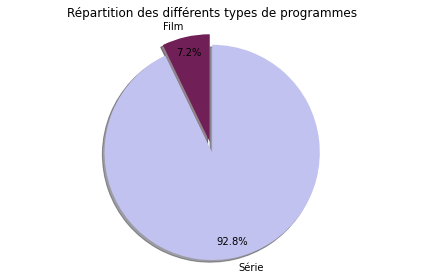

In [32]:
cur = collection_viki.aggregate([{"$group" : {"_id" : "$Type", "TypeShows" : {"$sum" : 1}}}])
res = pd.DataFrame(list(cur))
explode = (0.05, 0.05)
colors = ['#701f57', '#c2c2f0']

fig1,ax1 = plt.subplots()
type_shows = res['TypeShows']
labels = res['_id']
ax1.pie(type_shows, explode=explode, labels=labels, pctdistance=0.85, autopct='%1.1f%%', shadow=True, colors=colors,startangle=90)
ax1.axis('equal')
ax1.set_title('Répartition des différents types de programmes')
plt.tight_layout()
plt.show()

Le deuxième permet de déterminer le nombre de programmes en fonction du pays

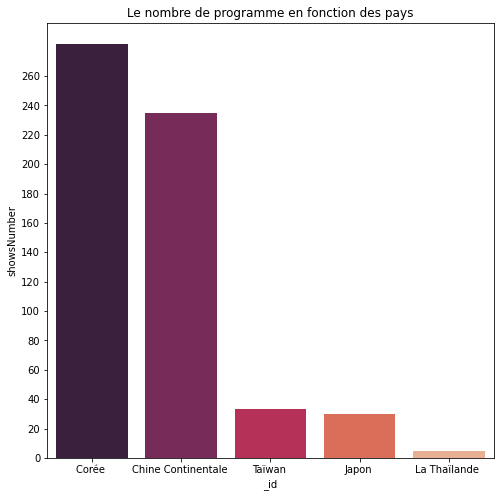

In [35]:
cur = collection_viki.aggregate([{"$group" : {"_id" : "$Pays", "showsNumber" : {"$sum" : 1}}},{'$sort':{'showsNumber':-1}}])
res = pd.DataFrame(list(cur))
plt.figure( figsize = (8,8) )
plt.title('Le nombre de programme en fonction des pays')
sns.barplot(x='_id',y='showsNumber',data=res,palette='rocket')
plt.yticks(np.arange(0, 270, 20))
plt.show()

Le dernier permet de déterminer quels sont les pays d'où les 5 meilleures séries sont originaires

Text(0.5, 1.0, 'Répartition des 5 meilleures séries')

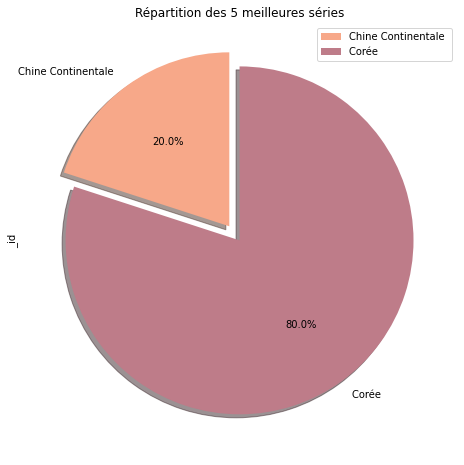

In [36]:
cur = collection_viki.find({'Type':'Série'}).sort('Note',-1).limit(5)
df_res = pd.DataFrame(list(cur))
explode=[.1,0]
colors = ['#f7a889', '#be7c89']
df_res.pivot_table('_id',index='Pays',aggfunc='count').plot(kind='pie',subplots=True,colors = colors, explode=explode, autopct='%1.1f%%', shadow=True,figsize=(8,8),startangle=90)
plt.legend(loc='upper right')
plt.title('Répartition des 5 meilleures séries')